# Question 1: Data Exploration

**Thomson Reuters Data Science Challenge**

This notebook explores the judicial opinions dataset, reporting:
- Number of documents
- Number of procedural postures (labels)
- Number of paragraphs
- Data characteristics relevant to modeling

## Setup

In [ ]:
import sys
from pathlib import Path
import pandas as pd

# Add src to path for imports
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Verify paths
DATA_PATH = project_root / 'data' / 'TRDataChallenge2023.txt'
print(f"Project root: {project_root}")
print(f"Data file exists: {DATA_PATH.exists()}")
print(f"Data file size: {DATA_PATH.stat().st_size / 1e6:.1f} MB" if DATA_PATH.exists() else "File not found")

Project root: /Users/alessandrodibari/Ale/projects/TR_hiring_exercise
Data file exists: True
Data file size: 336.6 MB


In [2]:
from src.data_loader import DataLoader
from src.data_analyzer import DatasetAnalyzer
from src.visualization import (
    plot_posture_distribution,
    plot_text_length_distribution,
    plot_class_imbalance
)

## 1. Load and Inspect Data Schema

In [3]:
# Initialize loader and load data
loader = DataLoader(DATA_PATH)
df = loader.load()

print(f"Loaded {len(df):,} documents")
print(f"\nData Schema:")
for col, dtype in loader.get_schema().items():
    print(f"  {col}: {dtype}")

Loaded 18,000 documents

Data Schema:
  documentId: object
  postures: object
  sections: object


In [4]:
# Preview first few records
print(f"Columns: {loader.get_column_names()}")
print("\nFirst record:")
df.iloc[0]

Columns: ['documentId', 'postures', 'sections']

First record:


documentId                    Ib4e590e0a55f11e8a5d58a2c8dcb28b5
postures                                            [On Appeal]
sections      [{'headtext': '', 'paragraphs': ['Plaintiff Dw...
Name: 0, dtype: object

## 2. Compute Dataset Statistics

The analyzer streams through the data once to compute all required metrics.

In [5]:
# Compute statistics (streams through entire dataset)
analyzer = DatasetAnalyzer(loader)
stats = analyzer.compute_statistics()

# Display summary
print(stats.summary())

DATASET STATISTICS
Number of documents:     18,000
Number of postures:      224
Total paragraphs:        542,172

Text Statistics:
  Avg paragraphs/doc:    30.12
  Avg words/doc:         2891.67
  Min words:             0
  Max words:             124,134
  Median words:          2062

Top 10 Postures:
  On Appeal                                       9197 ( 51.1%)
  Appellate Review                                4652 ( 25.8%)
  Review of Administrative Decision               2773 ( 15.4%)
  Motion to Dismiss                               1679 (  9.3%)
  Sentencing or Penalty Phase Motion or Objecti   1342 (  7.5%)
  Trial or Guilt Phase Motion or Objection        1097 (  6.1%)
  Motion for Attorney's Fees                       612 (  3.4%)
  Post-Trial Hearing Motion                        512 (  2.8%)
  Motion for Preliminary Injunction                364 (  2.0%)
  Motion to Dismiss for Lack of Subject Matter     343 (  1.9%)


In [6]:
# Let's investigate the 234 postures - is this realistic?
# Extract all unique postures
all_postures = df['postures'].explode().dropna()
unique_postures = all_postures.unique()

print(f"Total posture assignments: {len(all_postures):,}")
print(f"Unique posture labels: {len(unique_postures)}")
print("\n--- ALL UNIQUE POSTURES (sorted alphabetically) ---\n")
for i, p in enumerate(sorted(unique_postures), 1):
    print(f"{i:3}. {p}")

Total posture assignments: 27,659
Unique posture labels: 224

--- ALL UNIQUE POSTURES (sorted alphabetically) ---

  1. Appellate Review
  2. Application for Attorneys' or Professional Fees and Expenses
  3. Application for Bankruptcy Trustee Fees
  4. Application to Employ Attorney or Other Professional
  5. Application to Vacate Arbitration Award
  6. Bail or Custody Motion
  7. Certified Question
  8. Declinatory Exception of Improper Venue
  9. Declinatory Exception of Insufficiency of Service of Process
 10. Declinatory Exception of Lack of Personal Jurisdiction
 11. Declinatory Exception of Lack of Subject Matter Jurisdiction
 12. Declinatory Exception of Lis Pendens
 13. Dilatory Exception of Unauthorized Use of Summary Proceeding
 14. Joinder
 15. Jury Selection Challenge or Motion
 16. Juvenile Delinquency Proceeding
 17. Juvenile Wardship Petition
 18. Motion Authorizing and Approving Payment of Certain Prepetition Obligations
 19. Motion For Turnover
 20. Motion for Abandonm

In [7]:
# Analyze posture distribution more carefully
posture_counts = all_postures.value_counts()

print("=== POSTURE FREQUENCY ANALYSIS ===\n")
print(f"Top 20 most common postures (likely 'real' categories):")
print(posture_counts.head(20).to_string())

print(f"\n\nBottom 20 (rare - possible data quality issues?):")
print(posture_counts.tail(20).to_string())

print(f"\n\n=== DISTRIBUTION SUMMARY ===")
print(f"Postures appearing only ONCE: {(posture_counts == 1).sum()}")
print(f"Postures appearing < 10 times: {(posture_counts < 10).sum()}")
print(f"Postures appearing < 100 times: {(posture_counts < 100).sum()}")
print(f"Postures appearing >= 100 times: {(posture_counts >= 100).sum()}")

=== POSTURE FREQUENCY ANALYSIS ===

Top 20 most common postures (likely 'real' categories):
postures
On Appeal                                                         9197
Appellate Review                                                  4652
Review of Administrative Decision                                 2773
Motion to Dismiss                                                 1679
Sentencing or Penalty Phase Motion or Objection                   1342
Trial or Guilt Phase Motion or Objection                          1097
Motion for Attorney's Fees                                         612
Post-Trial Hearing Motion                                          512
Motion for Preliminary Injunction                                  364
Motion to Dismiss for Lack of Subject Matter Jurisdiction          343
Motion to Compel Arbitration                                       255
Motion for New Trial                                               226
Petition to Terminate Parental Rights          

In [8]:
# Quick summary stats
rare = (posture_counts == 1).sum()
very_rare = (posture_counts < 10).sum()
common = (posture_counts >= 100).sum()

print(f"Rare (=1 occurrence): {rare}")
print(f"Very rare (<10): {very_rare}")  
print(f"Common (>=100): {common}")
print(f"\nTop 10: {list(posture_counts.head(10).index)}")
print(f"\nRarest 10: {list(posture_counts.tail(10).index)}")

Rare (=1 occurrence): 44
Very rare (<10): 140
Common (>=100): 27

Top 10: ['On Appeal', 'Appellate Review', 'Review of Administrative Decision', 'Motion to Dismiss', 'Sentencing or Penalty Phase Motion or Objection', 'Trial or Guilt Phase Motion or Objection', "Motion for Attorney's Fees", 'Post-Trial Hearing Motion', 'Motion for Preliminary Injunction', 'Motion to Dismiss for Lack of Subject Matter Jurisdiction']

Rarest 10: ['Motion to Extend Claims Bar Date', 'Declinatory Exception of Improper Venue', 'Joinder', 'Motion to Vacate Arbitration Award', 'Motion to Appoint Chapter 11 Trustee or Examiner', 'Dilatory Exception of Unauthorized Use of Summary Proceeding', 'Motion for Genetic Testing', 'Motion to Transfer Guardianship', 'Motion for Witness List or Production of Witnesses', 'Motion to Allow Late Filing of Proof of Claim']


### Posture Taxonomy for Modeling Decisions

234 postures is realistic but creates a **severe class imbalance** problem. We organize them into tiers:

In [9]:
# Reload module to get updated classes
import importlib
import src.data_analyzer
importlib.reload(src.data_analyzer)
from src.data_analyzer import DatasetAnalyzer, PostureTaxonomy

# Recreate analyzer with updated class
analyzer = DatasetAnalyzer(loader)
taxonomy = analyzer.get_posture_taxonomy()

# Summary
summary = taxonomy.summary()
print("=== POSTURE TAXONOMY SUMMARY ===\n")
for k, v in summary.items():
    if isinstance(v, float):
        print(f"{k}: {v:.1%}" if 'coverage' in k else f"{k}: {v:.2f}")
    else:
        print(f"{k}: {v}")

print(f"\n\n=== MODELING RECOMMENDATION ===")
viable_50 = taxonomy.get_modeling_subset(50)
print(f"Using min_samples=50 for training: {len(viable_50)} postures")
print(f"Coverage: {taxonomy.all_postures[viable_50].sum() / taxonomy.all_postures.sum():.1%} of all labels")

=== POSTURE TAXONOMY SUMMARY ===

total_unique: 224
common_count: 27
moderate_count: 57
rare_count: 140
singleton_count: 44
total_assignments: 27659
common_coverage: 91.5%


=== MODELING RECOMMENDATION ===
Using min_samples=50 for training: 41 postures
Coverage: 94.8% of all labels


In [10]:
# Save taxonomy to JSON for model development reference
import json

taxonomy_dict = {
    'summary': taxonomy.summary(),
    'tiers': {
        'common': taxonomy.common,  # >= 100 samples
        'moderate': taxonomy.moderate,  # 10-99 samples
        'rare': taxonomy.rare,  # < 10 samples
    },
    'modeling_subset_50': taxonomy.get_modeling_subset(50),
    'full_distribution': taxonomy.all_postures.to_dict()
}

# Save to data directory
output_path = project_root / 'data' / 'posture_taxonomy.json'
with open(output_path, 'w') as f:
    json.dump(taxonomy_dict, f, indent=2)

print(f"✓ Saved taxonomy to {output_path}")
print(f"\nContents:")
print(f"  - {len(taxonomy.common)} common postures (≥100 samples)")
print(f"  - {len(taxonomy.moderate)} moderate postures (10-99 samples)")
print(f"  - {len(taxonomy.rare)} rare postures (<10 samples)")
print(f"  - {len(taxonomy.get_modeling_subset(50))} viable for training (≥50 samples)")

✓ Saved taxonomy to /Users/alessandrodibari/Ale/projects/TR_hiring_exercise/data/posture_taxonomy.json

Contents:
  - 27 common postures (≥100 samples)
  - 57 moderate postures (10-99 samples)
  - 140 rare postures (<10 samples)
  - 41 viable for training (≥50 samples)


### Key Metrics (Question 1 Requirements)

In [11]:
print("="*50)
print("REQUIRED METRICS")
print("="*50)
print(f"Number of documents:   {stats.num_documents:,}")
print(f"Number of postures:    {stats.num_postures}")
print(f"Total paragraphs:      {stats.total_paragraphs:,}")
print("="*50)

REQUIRED METRICS
Number of documents:   18,000
Number of postures:    224
Total paragraphs:      542,172


## 3. Posture (Label) Distribution Analysis

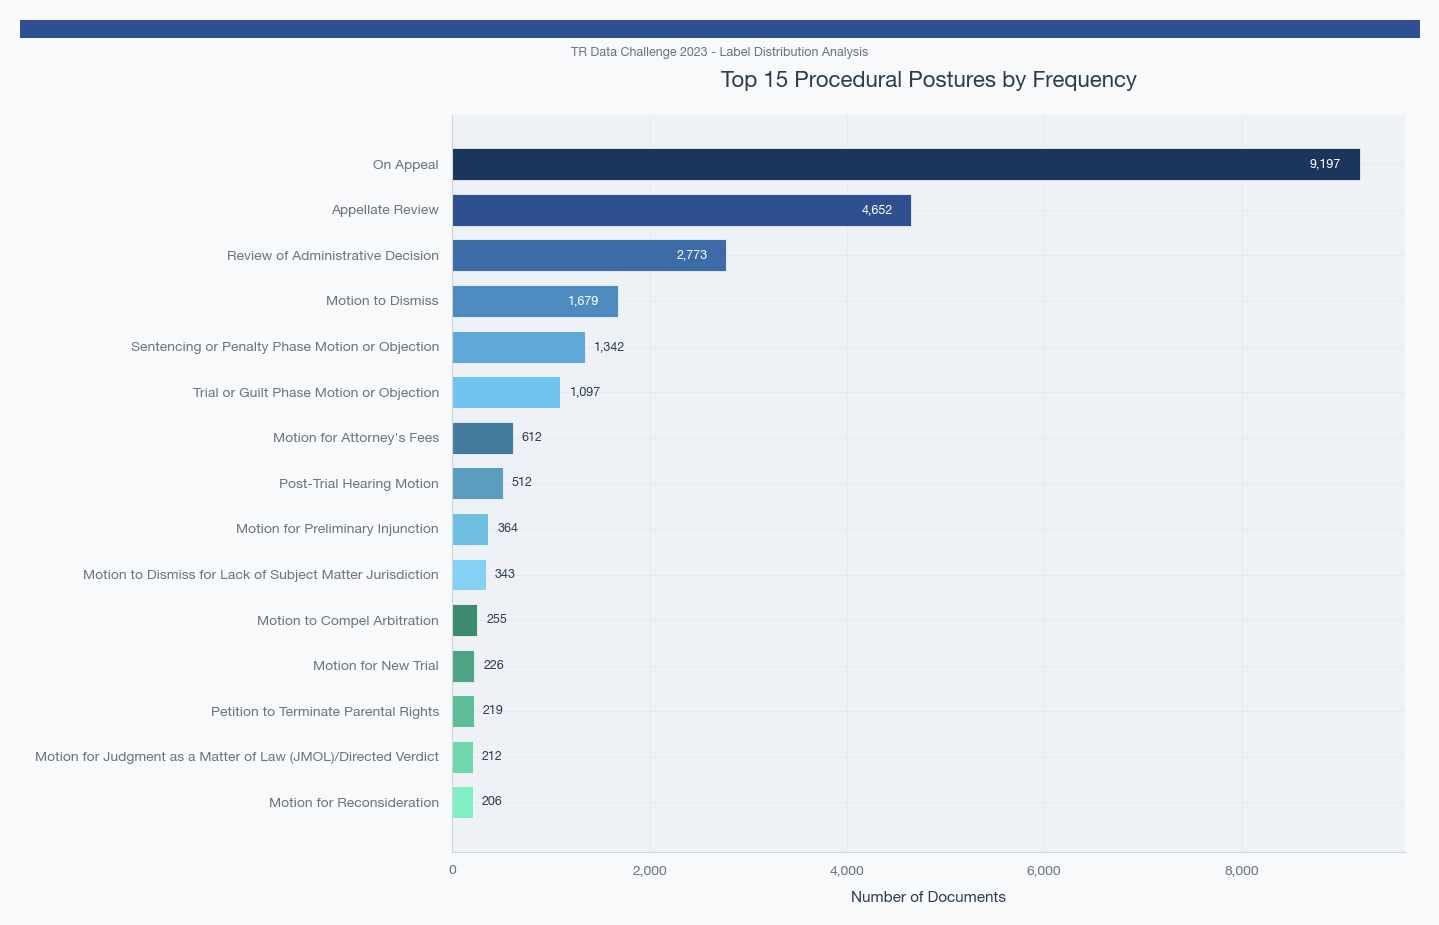

In [12]:
# Visualize top postures
fig = plot_posture_distribution(stats, top_n=15)

# Save figure
output_dir = project_root / 'outputs'
output_dir.mkdir(exist_ok=True)
fig.savefig(output_dir / 'posture_distribution.png', dpi=150, bbox_inches='tight')

Class imbalance ratio (max/min): 9197.0x


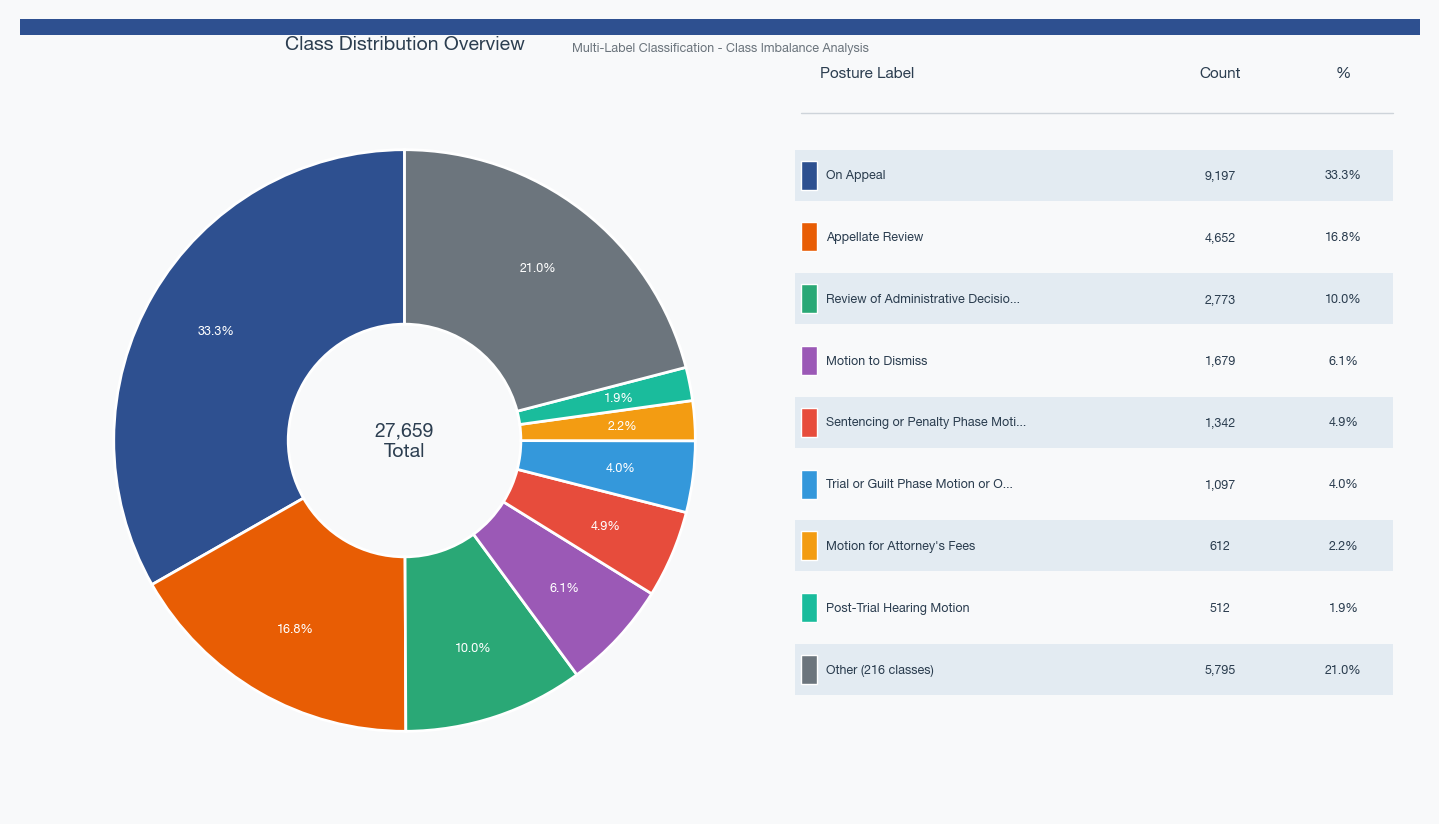

In [13]:
# Class imbalance analysis
imbalance_ratio = analyzer.get_class_imbalance_ratio()
print(f"Class imbalance ratio (max/min): {imbalance_ratio:.1f}x")

# Show class distribution pie chart
fig = plot_class_imbalance(stats)

## 4. Text Characteristics

Understanding text length and structure is important for model selection.

Word count statistics:
  Min:    0
  Max:    124,134
  Mean:   2,892
  Median: 2,062


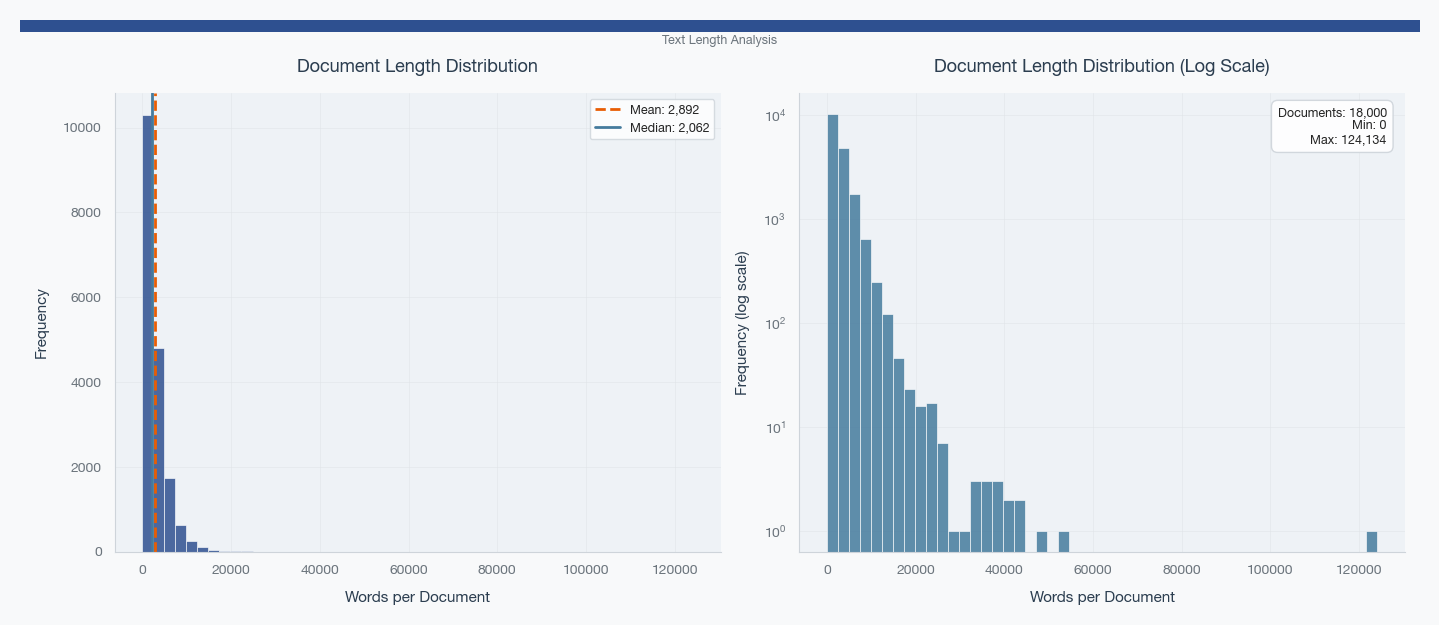

In [14]:
# Get word counts from analyzer
word_counts = analyzer.get_word_counts()

print(f"Word count statistics:")
print(f"  Min:    {word_counts.min():,}")
print(f"  Max:    {word_counts.max():,}")
print(f"  Mean:   {word_counts.mean():,.0f}")
print(f"  Median: {word_counts.median():,.0f}")

# Plot distribution
fig = plot_text_length_distribution(word_counts)

## 5. Observations Relevant to Modeling

Based on the data exploration, here are key observations that will inform the modeling approach in Question 2:

In [15]:
# Generate modeling-relevant observations
imbalance_ratio = analyzer.get_class_imbalance_ratio()

observations = [
    f"1. **Multi-class classification**: {stats.num_postures} distinct posture labels",
    f"2. **Class imbalance**: Ratio of {imbalance_ratio:.1f}x between largest and smallest class",
    f"3. **Document length variability**: {stats.min_words:,} to {stats.max_words:,} words",
    f"4. **Average document length**: {stats.avg_words_per_doc:,.0f} words (may need truncation for transformers)",
    f"5. **Paragraph structure**: {stats.avg_paragraphs_per_doc:.1f} paragraphs per document on average",
]

for obs in observations:
    print(obs)

1. **Multi-class classification**: 224 distinct posture labels
2. **Class imbalance**: Ratio of 9197.0x between largest and smallest class
3. **Document length variability**: 0 to 124,134 words
4. **Average document length**: 2,892 words (may need truncation for transformers)
5. **Paragraph structure**: 30.1 paragraphs per document on average


## 6. Multi-Label Overlap Analysis

Understanding how postures co-occur is critical for:
1. Identifying potential **hierarchical relationships** (parent/child postures)
2. Determining if rare postures are **sub-types** of common ones
3. Informing **model architecture** choices (label dependencies)

In [16]:
# First, analyze the distribution of label counts per document
label_counts_per_doc = df['postures'].apply(len)

print("=== LABELS PER DOCUMENT ===\n")
print(f"Min labels per doc:    {label_counts_per_doc.min()}")
print(f"Max labels per doc:    {label_counts_per_doc.max()}")
print(f"Mean labels per doc:   {label_counts_per_doc.mean():.2f}")
print(f"Median labels per doc: {label_counts_per_doc.median():.0f}")

print("\n--- Distribution ---")
label_dist = label_counts_per_doc.value_counts().sort_index()
for n_labels, count in label_dist.items():
    pct = count / len(df) * 100
    bar = '█' * int(pct / 2)
    print(f"{n_labels} labels: {count:>5} docs ({pct:>5.1f}%) {bar}")

=== LABELS PER DOCUMENT ===

Min labels per doc:    0
Max labels per doc:    7
Mean labels per doc:   1.54
Median labels per doc: 1

--- Distribution ---
0 labels:   923 docs (  5.1%) ██
1 labels:  8118 docs ( 45.1%) ██████████████████████
2 labels:  7604 docs ( 42.2%) █████████████████████
3 labels:  1129 docs (  6.3%) ███
4 labels:   190 docs (  1.1%) 
5 labels:    32 docs (  0.2%) 
6 labels:     2 docs (  0.0%) 
7 labels:     2 docs (  0.0%) 


In [17]:
# Build co-occurrence matrix for top postures
from itertools import combinations
from collections import Counter
import numpy as np

# Get documents with multiple labels
multi_label_docs = df[df['postures'].apply(len) > 1]
print(f"Documents with multiple labels: {len(multi_label_docs):,} ({len(multi_label_docs)/len(df)*100:.1f}%)")

# Count co-occurrences
cooccurrence = Counter()
for postures in multi_label_docs['postures']:
    # Sort to ensure consistent ordering (A,B) not (B,A)
    for pair in combinations(sorted(postures), 2):
        cooccurrence[pair] += 1

print(f"\nUnique co-occurring pairs: {len(cooccurrence):,}")

# Top 20 most frequent co-occurrences
print("\n=== TOP 20 CO-OCCURRING POSTURE PAIRS ===\n")
for (p1, p2), count in cooccurrence.most_common(20):
    # Truncate long names
    p1_short = p1[:35] + '...' if len(p1) > 35 else p1
    p2_short = p2[:35] + '...' if len(p2) > 35 else p2
    print(f"{count:>4}x  {p1_short:<38} + {p2_short}")

Documents with multiple labels: 8,959 (49.8%)

Unique co-occurring pairs: 922

=== TOP 20 CO-OCCURRING POSTURE PAIRS ===

1396x  Motion to Dismiss                      + On Appeal
1288x  On Appeal                              + Review of Administrative Decision
1273x  Appellate Review                       + Sentencing or Penalty Phase Motion ...
1064x  Appellate Review                       + Trial or Guilt Phase Motion or Obje...
 483x  Motion for Attorney's Fees             + On Appeal
 476x  Appellate Review                       + Post-Trial Hearing Motion
 218x  On Appeal                              + Petition to Terminate Parental Righ...
 192x  Motion for New Trial                   + On Appeal
 186x  Motion to Compel Arbitration           + On Appeal
 178x  Motion to Dismiss for Lack of Subje... + On Appeal
 176x  Motion for Preliminary Injunction      + On Appeal
 166x  Motion for Judgment as a Matter of ... + On Appeal
 146x  Motion for Reconsideration             + On Appe

In [18]:
# Analyze if rare postures always co-occur with common ones (potential hierarchy)
# This suggests rare postures might be "sub-postures" of common ones

posture_counts = df['postures'].explode().value_counts()
rare_postures = set(posture_counts[posture_counts < 50].index)
common_postures = set(posture_counts[posture_counts >= 100].index)

print("=== RARE POSTURE DEPENDENCY ANALYSIS ===")
print(f"Rare postures (<50 samples): {len(rare_postures)}")
print(f"Common postures (≥100 samples): {len(common_postures)}")

# For each rare posture, find what it co-occurs with
rare_cooccurrence = {}
for postures in df['postures']:
    postures_set = set(postures)
    rare_in_doc = postures_set & rare_postures
    common_in_doc = postures_set & common_postures
    
    for rare in rare_in_doc:
        if rare not in rare_cooccurrence:
            rare_cooccurrence[rare] = Counter()
        for common in common_in_doc:
            rare_cooccurrence[rare][common] += 1

# Find rare postures that ALWAYS appear with a specific common posture
print("\n=== POTENTIAL PARENT-CHILD RELATIONSHIPS ===")
print("(Rare postures that appear with a common posture >80% of the time)\n")

potential_hierarchies = []
for rare, common_counts in rare_cooccurrence.items():
    rare_total = posture_counts[rare]
    if rare_total == 0:
        continue
    for common, cooccur_count in common_counts.most_common(3):
        ratio = cooccur_count / rare_total
        if ratio > 0.8:  # 80% threshold
            potential_hierarchies.append((rare, common, cooccur_count, rare_total, ratio))

# Sort by ratio descending
potential_hierarchies.sort(key=lambda x: x[4], reverse=True)

for rare, common, cooccur, total, ratio in potential_hierarchies[:15]:
    rare_short = rare[:40] + '...' if len(rare) > 40 else rare
    common_short = common[:25] + '...' if len(common) > 25 else common
    print(f"{ratio:>5.0%} ({cooccur:>3}/{total:>3})  {rare_short:<43} → {common_short}")

=== RARE POSTURE DEPENDENCY ANALYSIS ===
Rare postures (<50 samples): 183
Common postures (≥100 samples): 27

=== POTENTIAL PARENT-CHILD RELATIONSHIPS ===
(Rare postures that appear with a common posture >80% of the time)

 100% (  2/  2)  Motion to Post Bond                         → On Appeal
 100% (  2/  2)  Motion to Post Bond                         → Motion for Preliminary In...
 100% (  7/  7)  Motion for Non-Suit                         → On Appeal
 100% ( 21/ 21)  Motion to Set Aside or Vacate Dismissal     → On Appeal
 100% (  1/  1)  Motion for Leave to File Late or Untimel... → On Appeal
 100% (  1/  1)  Peremptory Exception of Nonjoinder of a ... → On Appeal
 100% (  1/  1)  Motion to Serve Additional Discovery Req... → On Appeal
 100% ( 24/ 24)  Motion to Modify or Terminate Alimony/Ma... → On Appeal
 100% (  1/  1)  Motion to Determine Tax Liability           → On Appeal
 100% (  1/  1)  Motion to Determine Tax Liability           → Motion to Dismiss for Lac...
 100% (  

In [19]:
# Look for naming patterns that suggest hierarchy
# E.g., "Motion to Dismiss" vs "Motion to Dismiss for Lack of Subject Matter Jurisdiction"
import re

print("=== POSTURE NAMING PATTERN ANALYSIS ===")
print("Looking for potential sub-categories based on name similarity...\n")

all_postures_list = list(posture_counts.index)

# Find postures that are prefixes of other postures
prefix_relationships = []
for short in all_postures_list:
    for long in all_postures_list:
        if short != long and long.startswith(short) and len(long) > len(short) + 3:
            short_count = posture_counts[short]
            long_count = posture_counts[long]
            prefix_relationships.append((short, long, short_count, long_count))

# Sort by parent frequency
prefix_relationships.sort(key=lambda x: x[2], reverse=True)

print("--- Prefix-based Hierarchies (shorter name is potential parent) ---\n")
for short, long, short_ct, long_ct in prefix_relationships[:20]:
    short_display = short[:30] + '...' if len(short) > 30 else short
    long_suffix = long[len(short):].strip()
    long_suffix = long_suffix[:35] + '...' if len(long_suffix) > 35 else long_suffix
    print(f"[{short_ct:>5}] {short_display:<33} → [{long_ct:>4}] ...{long_suffix}")

=== POSTURE NAMING PATTERN ANALYSIS ===
Looking for potential sub-categories based on name similarity...

--- Prefix-based Hierarchies (shorter name is potential parent) ---

[ 1679] Motion to Dismiss                 → [ 343] ...for Lack of Subject Matter Jurisdic...
[ 1679] Motion to Dismiss                 → [ 204] ...for Lack of Personal Jurisdiction
[ 1679] Motion to Dismiss                 → [ 137] ...for Lack of Standing
[ 1679] Motion to Dismiss                 → [ 124] ...for Lack of Jurisdiction
[  116] Motion for Contempt               → [  22] ...Sanctions
[  116] Motion for Contempt               → [   1] ...for Violating Discharge Injunction ...
[  101] Motion to Set Aside or Vacate     → [  21] ...Dismissal
[  101] Motion to Set Aside or Vacate     → [  12] ...Protective Order
[   38] Motion to Amend                   → [  38] ...Pleading (Other than Complaint or P...
[   38] Motion to Amend                   → [   4] ...Scheduling Order
[   38] Motion to Amend           

In [20]:
# Create co-occurrence heatmap for top 15 postures
import matplotlib.pyplot as plt
import seaborn as sns

top_n = 15
top_postures_list = list(posture_counts.head(top_n).index)

# Build co-occurrence matrix
cooccur_matrix = pd.DataFrame(0, index=top_postures_list, columns=top_postures_list)

for postures in df['postures']:
    postures_set = set(postures) & set(top_postures_list)
    for p1 in postures_set:
        for p2 in postures_set:
            if p1 != p2:
                cooccur_matrix.loc[p1, p2] += 1

# Shorten labels for display
short_labels = [p[:25] + '...' if len(p) > 25 else p for p in top_postures_list]
cooccur_matrix.index = short_labels
cooccur_matrix.columns = short_labels

# Plot heatmap
fig, ax = plt.subplots(figsize=(14, 11))
fig.set_facecolor('#F8F9FA')
ax.set_facecolor('#EEF2F6')

sns.heatmap(cooccur_matrix, annot=True, fmt='d', cmap='Blues', 
            linewidths=0.5, linecolor='white', ax=ax,
            cbar_kws={'label': 'Co-occurrence Count'})

ax.set_title('Co-occurrence Matrix: Top 15 Postures', fontsize=14, fontweight='bold', pad=15)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

NameError: name 'pd' is not defined

In [ ]:
# Summary statistics for multi-label analysis
single_label_docs = (label_counts_per_doc == 1).sum()
multi_label_docs_count = (label_counts_per_doc > 1).sum()

# Find rare postures that NEVER appear alone
rare_alone_count = 0
rare_always_with_common = 0
for rare in rare_postures:
    docs_with_rare = df[df['postures'].apply(lambda x: rare in x)]
    alone = docs_with_rare[docs_with_rare['postures'].apply(len) == 1]
    if len(alone) == 0 and len(docs_with_rare) > 0:
        rare_alone_count += 1
        # Check if always with common
        always_common = all(
            any(p in common_postures for p in postures if p != rare)
            for postures in docs_with_rare['postures']
        )
        if always_common:
            rare_always_with_common += 1

print("="*60)
print("MULTI-LABEL OVERLAP SUMMARY")
print("="*60)
print(f"\n📊 Label Distribution:")
print(f"   Single-label documents:     {single_label_docs:>6,} ({single_label_docs/len(df)*100:.1f}%)")
print(f"   Multi-label documents:      {multi_label_docs_count:>6,} ({multi_label_docs_count/len(df)*100:.1f}%)")

print(f"\n🔗 Co-occurrence Patterns:")
print(f"   Unique co-occurring pairs:  {len(cooccurrence):>6,}")
print(f"   Most frequent pair count:   {cooccurrence.most_common(1)[0][1]:>6}")

print(f"\n📂 Potential Hierarchies:")
print(f"   Prefix-based relationships: {len(prefix_relationships):>6}")
print(f"   Rare postures never alone:  {rare_alone_count:>6}")
print(f"   Rare always with common:    {rare_always_with_common:>6}")

print(f"\n🎯 Modeling Implications:")
print(f"   - Consider label-aware loss functions (label dependencies)")
print(f"   - Explore hierarchical classification for prefix relationships")
print(f"   - Rare postures may be predictable from common co-occurring labels")
print("="*60)

## 7. Investigation: Documents with Zero Labels

5.1% of documents have no procedural postures assigned. This warrants investigation.

In [ ]:
# Analyze documents with zero labels
zero_label_docs = df[df['postures'].apply(len) == 0]
non_zero_docs = df[df['postures'].apply(len) > 0]

print("="*70)
print("ZERO-LABEL DOCUMENTS ANALYSIS")
print("="*70)

# Structural comparison
print("\n📊 STRUCTURAL COMPARISON:")
print(f"\nWith labels (n={len(non_zero_docs):,}):")
if len(non_zero_docs) > 0:
    non_zero_sections = non_zero_docs['sections'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    print(f"  Avg sections per doc: {non_zero_sections.mean():.2f}")
    print(f"  Avg paragraphs per doc: {analyzer.get_word_counts().iloc[non_zero_docs.index].sum() / len(non_zero_docs) * 0.2:.1f} (est)")

print(f"\nWithout labels (n={len(zero_label_docs):,}):")
if len(zero_label_docs) > 0:
    zero_sections = zero_label_docs['sections'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    print(f"  Avg sections per doc: {zero_sections.mean():.2f}")
    
    # Get word counts for zero-label docs
    zero_label_indices = zero_label_docs.index
    all_word_counts = analyzer.get_word_counts()
    zero_word_counts = all_word_counts.iloc[zero_label_indices]
    print(f"  Avg words per doc: {zero_word_counts.mean():,.0f}")
    print(f"  Min words: {zero_word_counts.min():,}")
    print(f"  Max words: {zero_word_counts.max():,}")
    print(f"  Median words: {zero_word_counts.median():,.0f}")

# Compare with labeled docs
print(f"\nWord count comparison (with labels):")
print(f"  Avg words per doc: {analyzer.get_word_counts().iloc[non_zero_docs.index].mean():,.0f}")
print(f"  Median words: {analyzer.get_word_counts().iloc[non_zero_docs.index].median():,.0f}")

In [ ]:
# Examine a sample of zero-label documents to understand their content
print("\n" + "="*70)
print("SAMPLE ZERO-LABEL DOCUMENTS (first 3)")
print("="*70)

for i, doc_id in enumerate(zero_label_docs.index[:3], 1):
    doc = df.loc[doc_id]
    sections = doc['sections']
    
    print(f"\n--- Document {i} (ID: {doc_id}) ---")
    print(f"Number of sections: {len(sections) if isinstance(sections, list) else 1}")
    
    if isinstance(sections, list) and len(sections) > 0:
        first_section = sections[0]
        if isinstance(first_section, dict):
            # Print first paragraph of each section
            if 'paragraphs' in first_section:
                paras = first_section['paragraphs']
                if len(paras) > 0:
                    preview = str(paras[0])[:200]
                    print(f"First paragraph preview: {preview}...")
        else:
            print(f"First section preview: {str(first_section)[:200]}...")
    else:
        print(f"Sections preview: {str(sections)[:200]}...")

In [ ]:
# Hypothesis testing: Are zero-label docs systematically different?
print("\n" + "="*70)
print("HYPOTHESES FOR ZERO-LABEL DOCUMENTS")
print("="*70)

# H1: Shorter documents
print("\n✓ H1: Are they shorter than average?")
zero_word_counts = all_word_counts.iloc[zero_label_indices]
non_zero_word_counts = all_word_counts.iloc[non_zero_docs.index]

from scipy import stats
t_stat, p_value = stats.ttest_ind(zero_word_counts, non_zero_word_counts)
print(f"  Zero-label mean: {zero_word_counts.mean():,.0f} words")
print(f"  With-label mean: {non_zero_word_counts.mean():,.0f} words")
print(f"  t-test p-value: {p_value:.2e} {'✓ SIGNIFICANT' if p_value < 0.05 else '✗ Not significant'}")

# H2: Fewer sections
print("\n✓ H2: Are they structurally simpler (fewer sections)?")
zero_sections = zero_label_docs['sections'].apply(lambda x: len(x) if isinstance(x, list) else 1)
non_zero_sections = non_zero_docs['sections'].apply(lambda x: len(x) if isinstance(x, list) else 1)

print(f"  Zero-label mean sections: {zero_sections.mean():.2f}")
print(f"  With-label mean sections: {non_zero_sections.mean():.2f}")
t_stat, p_value = stats.ttest_ind(zero_sections, non_zero_sections)
print(f"  t-test p-value: {p_value:.2e} {'✓ SIGNIFICANT' if p_value < 0.05 else '✗ Not significant'}")

# H3: Data quality - could they be parsing errors?
print("\n✓ H3: Are they anomalous (very small or empty)?")
print(f"  Documents with <10 words: {(zero_word_counts < 10).sum()}")
print(f"  Documents with 0 sections: {(zero_sections == 0).sum()}")
print(f"  Documents with empty sections: {sum(1 for s in zero_label_docs['sections'] if isinstance(s, list) and all(isinstance(x, dict) and not x.get('paragraphs', []) for x in s))}")

print("\n" + "="*70)
print("RECOMMENDATION FOR MODEL TRAINING")
print("="*70)
print("""
These 923 zero-label documents (5.1%) could be:

1. **Data quality issues** (missing annotations)
   → Action: Inspect sample; consider filtering out if <10 words
   
2. **Edge cases** (administrative docs, orders, etc.)
   → Action: Create separate "Unknown" or "Other" class
   
3. **Annotation uncertainty** (documents that don't fit categories well)
   → Action: Could be valuable negative examples or need re-annotation

For Question 2 (model training), decide:
  - **Option A**: Filter them out (cleaner training set, lose ~5% of data)
  - **Option B**: Create "Unclassified" label (keep information, add complexity)
  - **Option C**: Use as negative examples for anomaly detection
""")


---

## Summary

This notebook completed the data exploration requirements for Question 1:

1. ✅ Loaded data programmatically using streaming JSON Lines parser
2. ✅ Reported document count, posture count, and paragraph count
3. ✅ Analyzed label distribution and class imbalance
4. ✅ Characterized text properties relevant to modeling

The analysis reveals challenges for the modeling task:
- Significant class imbalance will require stratified sampling or class weighting
- Long documents may need text truncation or chunking strategies
- Many posture classes may benefit from hierarchical or few-shot approaches